# EEG Project Group 12

## Obtaining Data and Performing Preprocessing


### Importing Required Libraries

From here upto and including EEG Feature Extraction was taken from the sample example

In [72]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
## Version history:

2018:
	Original script by Dr. Luis Manso [lmanso], Aston University
	
2019, June:
	Revised, commented and updated by Dr. Felipe Campelo [fcampelo], Aston University
	(f.campelo@aston.ac.uk / fcampelo@gmail.com)
"""

# Commented since not used. [fcampelo]
# import sys
#from scipy.spatial.distance import euclidean

import numpy as np
import scipy
import scipy.signal

def matrix_from_csv_file(file_path):
	"""
	Returns the data matrix given the path of a CSV file.
	
	Parameters:
		file_path (str): path for the CSV file with a time stamp in the first column
			and the signals in the subsequent ones.
			Time stamps are in seconds, with millisecond precision

    Returns:
		numpy.ndarray: 2D matrix containing the data read from the CSV
	
	Author: 
		Original: [lmanso] 
		Revision and documentation: [fcampelo]
	
	"""
	
	csv_data = np.genfromtxt(file_path, delimiter = ',')
	full_matrix = csv_data[1:]
	#headers = csv_data[0] # Commented since not used or returned [fcampelo]
	
	return full_matrix


def get_time_slice(full_matrix, start = 0., period = 1.):
	"""
	Returns a slice of the given matrix, where start is the offset and period is 
	used to specify the length of the signal.
	
	Parameters:
		full_matrix (numpy.ndarray): matrix returned by matrix_from_csv()
		start (float): start point (in seconds after the beginning of records) 
		period (float): duration of the slice to be extracted (in seconds)

	Returns:
		numpy.ndarray: 2D matrix with the desired slice of the matrix
		float: actual length of the resulting time slice
		
	Author:
		Original: [lmanso]
		Reimplemented: [fcampelo]
	"""
	
	# Changed for greater efficiency [fcampelo]
	rstart  = full_matrix[0, 0] + start
	index_0 = np.max(np.where(full_matrix[:, 0] <= rstart))
	index_1 = np.max(np.where(full_matrix[:, 0] <= rstart + period))
	
	duration = full_matrix[index_1, 0] - full_matrix[index_0, 0]
	return full_matrix[index_0:index_1, :], duration


def feature_mean(matrix):
	"""
	Returns the mean value of each signal for the full time window
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		
	Returns:
		numpy.ndarray: 1D array containing the means of each column from the input matrix
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	"""
	
	ret = np.mean(matrix, axis = 0).flatten()
	names = ['mean_' + str(i) for i in range(matrix.shape[1])]
	return ret, names



def feature_mean_d(h1, h2):
	"""
	Computes the change in the means (backward difference) of all signals 
	between the first and second half-windows, mean(h2) - mean(h1)
	
	Parameters:
		h1 (numpy.ndarray): 2D matrix containing the signals for the first 
		half-window
		h2 (numpy.ndarray): 2D matrix containing the signals for the second 
		half-window
		
	Returns:
		numpy.ndarray: 1D array containing the difference between the mean in h2 
		and the mean in h1 of all signals
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	
	"""
	ret = (feature_mean(h2)[0] - feature_mean(h1)[0]).flatten()
	
	
	# Fixed naming [fcampelo]
	names = ['mean_d_h2h1_' + str(i) for i in range(h1.shape[1])]
	return ret, names



def feature_mean_q(q1, q2, q3, q4):
	"""
	Computes the mean values of each signal for each quarter-window, plus the 
	paired differences of means of each signal for the quarter-windows, i.e.,
	feature_mean(q1), feature_mean(q2), feature_mean(q3), feature_mean(q4),
	(feature_mean(q1) - feature_mean(q2)), (feature_mean(q1) - feature_mean(q3)),
	...
	
	Parameters:
		q1 (numpy.ndarray): 2D matrix containing the signals for the first 
		quarter-window
		q2 (numpy.ndarray): 2D matrix containing the signals for the second 
		quarter-window
		q3 (numpy.ndarray): 2D matrix containing the signals for the third 
		quarter-window
		q4 (numpy.ndarray): 2D matrix containing the signals for the fourth 
		quarter-window
		
	Returns:
		numpy.ndarray: 1D array containing the means of each signal in q1, q2, 
		q3 and q4; plus the paired differences of the means of each signal on 
		each quarter-window.
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	
	"""
	v1 = feature_mean(q1)[0]
	v2 = feature_mean(q2)[0]
	v3 = feature_mean(q3)[0]
	v4 = feature_mean(q4)[0]
	ret = np.hstack([v1, v2, v3, v4, 
				     v1 - v2, v1 - v3, v1 - v4, 
					 v2 - v3, v2 - v4, v3 - v4]).flatten()
	
	
	# Fixed naming [fcampelo]
	names = []
	for i in range(4): # for all quarter-windows
		names.extend(['mean_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])
	
	for i in range(3): # for quarter-windows 1-3
		for j in range((i + 1), 4): # and quarter-windows (i+1)-4
			names.extend(['mean_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])
			 
	return ret, names




def feature_stddev(matrix):
	"""
	Computes the standard deviation of each signal for the full time window
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		
	Returns:
		numpy.ndarray: 1D array containing the standard deviation of each column 
		from the input matrix
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	"""
	
	# fix ddof for finite sampling correction (N-1 instead of N in denominator)
	ret = np.std(matrix, axis = 0, ddof = 1).flatten()
	names = ['std_' + str(i) for i in range(matrix.shape[1])]
	
	return ret, names



def feature_stddev_d(h1, h2):
	"""
	Computes the change in the standard deviations (backward difference) of all 
	signals between the first and second half-windows, std(h2) - std(h1)
	
	Parameters:
		h1 (numpy.ndarray): 2D matrix containing the signals for the first 
		half-window
		h2 (numpy.ndarray): 2D matrix containing the signals for the second 
		half-window
		
	Returns:
		numpy.ndarray: 1D array containing the difference between the stdev in h2 
		and the stdev in h1 of all signals
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	
	"""
	
	ret = (feature_stddev(h2)[0] - feature_stddev(h1)[0]).flatten()
	
	# Fixed naming [fcampelo]
	names = ['std_d_h2h1_' + str(i) for i in range(h1.shape[1])]
	
	return ret, names




def feature_moments(matrix):
	"""
	Computes the 3rd and 4th standardised moments about the mean (i.e., skewness 
	and kurtosis) of each signal, for the full time window. Notice that 
	scipy.stats.moments() returns the CENTRAL moments, which need to be 
	standardised to compute skewness and kurtosis.
	Notice: Kurtosis is calculated as excess kurtosis, e.g., with the Gaussian 
	kurtosis set as the zero point (Fisher's definition)
	- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kurtosis.html
	- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skew.html
	- https://en.wikipedia.org/wiki/Standardized_moment
	- http://www.econ.nyu.edu/user/ramseyj/textbook/pg93.99.pdf
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		
	Returns:
		numpy.ndarray: 1D array containing the skewness and kurtosis of each 
		column from the input matrix
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [fcampelo]
	"""

	skw = scipy.stats.skew(matrix, axis = 0, bias = False)
	krt = scipy.stats.kurtosis(matrix, axis = 0, bias = False)
	ret  = np.append(skw, krt)
		
	names = ['skew_' + str(i) for i in range(matrix.shape[1])]
	names.extend(['kurt_' + str(i) for i in range(matrix.shape[1])])
	return ret, names




def feature_max(matrix):
	"""
	Returns the maximum value of each signal for the full time window
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		
	Returns:
		numpy.ndarray: 1D array containing the max of each column from the input matrix
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	"""
	
	ret = np.max(matrix, axis = 0).flatten()
	names = ['max_' + str(i) for i in range(matrix.shape[1])]
	return ret, names



def feature_max_d(h1, h2):
	"""
	Computes the change in max values (backward difference) of all signals 
	between the first and second half-windows, max(h2) - max(h1)
	
	Parameters:
		h1 (numpy.ndarray): 2D matrix containing the signals for the first 
		half-window
		h2 (numpy.ndarray): 2D matrix containing the signals for the second 
		half-window
		
	Returns:
		numpy.ndarray: 1D array containing the difference between the max in h2 
		and the max in h1 of all signals
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	
	"""
	
	ret = (feature_max(h2)[0] - feature_max(h1)[0]).flatten()
	
	# Fixed naming [fcampelo]
	names = ['max_d_h2h1_' + str(i) for i in range(h1.shape[1])]
	return ret, names


def feature_max_q(q1, q2, q3, q4):
	"""
	Computes the max values of each signal for each quarter-window, plus the 
	paired differences of max values of each signal for the quarter-windows, 
	i.e., feature_max(q1), feature_max(q2), feature_max(q3), feature_max(q4),
	(feature_max(q1) - feature_max(q2)), (feature_max(q1) - feature_max(q3)),
	...
	
	Parameters:
		q1 (numpy.ndarray): 2D matrix containing the signals for the first 
		quarter-window
		q2 (numpy.ndarray): 2D matrix containing the signals for the second 
		quarter-window
		q3 (numpy.ndarray): 2D matrix containing the signals for the third 
		quarter-window
		q4 (numpy.ndarray): 2D matrix containing the signals for the fourth 
		quarter-window
		
	Returns:
		numpy.ndarray: 1D array containing the max of each signal in q1, q2, 
		q3 and q4; plus the paired differences of the max values of each signal 
		on each quarter-window.
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	
	"""
	v1 = feature_max(q1)[0]
	v2 = feature_max(q2)[0]
	v3 = feature_max(q3)[0]
	v4 = feature_max(q4)[0]
	ret = np.hstack([v1, v2, v3, v4, 
				     v1 - v2, v1 - v3, v1 - v4, 
					 v2 - v3, v2 - v4, v3 - v4]).flatten()
	
	
	# Fixed naming [fcampelo]
	names = []
	for i in range(4): # for all quarter-windows
		names.extend(['max_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])
	
	for i in range(3): # for quarter-windows 1-3
		for j in range((i + 1), 4): # and quarter-windows (i+1)-4
			names.extend(['max_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])
			 
	return ret, names


def feature_min(matrix):
	"""
	Returns the minimum value of each signal for the full time window
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		
	Returns:
		numpy.ndarray: 1D array containing the min of each column from the input matrix
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	"""
	
	ret = np.min(matrix, axis = 0).flatten()
	names = ['min_' + str(i) for i in range(matrix.shape[1])]
	return ret, names



def feature_min_d(h1, h2):
	"""
	Computes the change in min values (backward difference) of all signals 
	between the first and second half-windows, min(h2) - min(h1)
	
	Parameters:
		h1 (numpy.ndarray): 2D matrix containing the signals for the first 
		half-window
		h2 (numpy.ndarray): 2D matrix containing the signals for the second 
		half-window
		
	Returns:
		numpy.ndarray: 1D array containing the difference between the min in h2 
		and the min in h1 of all signals
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	
	"""
	
	ret = (feature_min(h2)[0] - feature_min(h1)[0]).flatten()
	
	# Fixed naming [fcampelo]
	names = ['min_d_h2h1_' + str(i) for i in range(h1.shape[1])]
	return ret, names


def feature_min_q(q1, q2, q3, q4):
	"""
	Computes the min values of each signal for each quarter-window, plus the 
	paired differences of min values of each signal for the quarter-windows, 
	i.e., feature_min(q1), feature_min(q2), feature_min(q3), feature_min(q4),
	(feature_min(q1) - feature_min(q2)), (feature_min(q1) - feature_min(q3)),
	...
	
	Parameters:
		q1 (numpy.ndarray): 2D matrix containing the signals for the first 
		quarter-window
		q2 (numpy.ndarray): 2D matrix containing the signals for the second 
		quarter-window
		q3 (numpy.ndarray): 2D matrix containing the signals for the third 
		quarter-window
		q4 (numpy.ndarray): 2D matrix containing the signals for the fourth 
		quarter-window
		
	Returns:
		numpy.ndarray: 1D array containing the min of each signal in q1, q2, 
		q3 and q4; plus the paired differences of the min values of each signal 
		on each quarter-window.
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	
	"""
	v1 = feature_min(q1)[0]
	v2 = feature_min(q2)[0]
	v3 = feature_min(q3)[0]
	v4 = feature_min(q4)[0]
	ret = np.hstack([v1, v2, v3, v4, 
				     v1 - v2, v1 - v3, v1 - v4, 
					 v2 - v3, v2 - v4, v3 - v4]).flatten()
	
	
	# Fixed naming [fcampelo]
	names = []
	for i in range(4): # for all quarter-windows
		names.extend(['min_q' + str(i + 1) + "_" + str(j) for j in range(len(v1))])
	
	for i in range(3): # for quarter-windows 1-3
		for j in range((i + 1), 4): # and quarter-windows (i+1)-4
			names.extend(['min_d_q' + str(i + 1) + 'q' + str(j + 1) + "_" + str(k) for k in range(len(v1))])
			 
	return ret, names


def feature_covariance_matrix(matrix):
	"""
	Computes the elements of the covariance matrix of the signals. Since the 
    covariance matrix is symmetric, only the lower triangular elements 
	(including the main diagonal elements, i.e., the variances of eash signal) 
	are returned. 
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		
	Returns:
		numpy.ndarray: 1D array containing the variances and covariances of the 
        signals
		list: list containing feature names for the quantities calculated.
		numpy.ndarray: 2D array containing the actual covariance matrix

	Author:
		Original: [fcampelo]
	"""
    
	covM = np.cov(matrix.T)
	indx = np.triu_indices(covM.shape[0])
	ret  = covM[indx]
	
	names = []
	for i in np.arange(0, covM.shape[1]):
		for j in np.arange(i, covM.shape[1]):
			names.extend(['covM_' + str(i) + '_' + str(j)])
	
	return ret, names, covM


def feature_eigenvalues(covM):
	"""
	Computes the eigenvalues of the covariance matrix passed as the function 
	argument.
	
	Parameters:
		covM (numpy.ndarray): 2D [nsignals x nsignals] covariance matrix of the 
		signals in a time window
		
	Returns:
		numpy.ndarray: 1D array containing the eigenvalues of the covariance 
		matrix
		list: list containing feature names for the quantities calculated.

	Author:
		Original: [lmanso]
		Revision and documentation: [fcampelo]
	"""
	
	ret   = np.linalg.eigvals(covM).flatten()
	names = ['eigenval_' + str(i) for i in range(covM.shape[0])]
	return ret, names


def feature_logcov(covM):
	"""
	Computes the matrix logarithm of the covariance matrix of the signals. 
	Since the matrix is symmetric, only the lower triangular elements 
	(including the main diagonal) are returned. 
	
	In the unlikely case that the matrix logarithm contains complex values the 
	vector of features returned will contain the magnitude of each component 
	(the covariance matrix returned will be in its original form). Complex 
	values should not happen, as the covariance matrix is always symmetric 
	and positive semi-definite, but the guarantee of real-valued features is in 
	place anyway. 
	
	Details:
		The matrix logarithm is defined as the inverse of the matrix 
		exponential. For a matrix B, the matrix exponential is
		
			$ exp(B) = \sum_{r=0}^{\inf} B^r / r! $,
		
		with 
		
			$ B^r = \prod_{i=1}^{r} B / r $.
			
		If covM = exp(B), then B is a matrix logarithm of covM.
	
	Parameters:
		covM (numpy.ndarray): 2D [nsignals x nsignals] covariance matrix of the 
		signals in a time window
		
	Returns:
		numpy.ndarray: 1D array containing the elements of the upper triangular 
		(incl. main diagonal) of the matrix logarithm of the covariance matrix.
		list: list containing feature names for the quantities calculated.
		numpy.ndarray: 2D array containing the matrix logarithm of covM
		

	Author:
		Original: [fcampelo]
	"""
	log_cov = scipy.linalg.logm(covM)
	indx = np.triu_indices(log_cov.shape[0])
	ret  = np.abs(log_cov[indx])
	
	names = []
	for i in np.arange(0, log_cov.shape[1]):
		for j in np.arange(i, log_cov.shape[1]):
			names.extend(['logcovM_' + str(i) + '_' + str(j)])
	
	return ret, names, log_cov



def feature_fft(matrix, period = 1., mains_f = 50., 
				filter_mains = True, filter_DC = True,
				normalise_signals = True,
				ntop = 10, get_power_spectrum = True):
	"""
	Computes the FFT of each signal. 
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		period (float): width (in seconds) of the time window represented by
		matrix
		mains_f (float): the frequency of mains power supply, in Hz.
		filter_mains (bool): should the mains frequency (plus/minus 1Hz) be 
		filtered out?
		filter_DC (bool): should the DC component be removed?
		normalise_signals (bool): should the signals be normalised to the 
		before interval [-1, 1] before computing the FFT?
		ntop (int): how many of the "top N" most energetic frequencies should 
		also be returned (in terms of the value of the frequency, not the power)
		get_power_spectrum (bool): should the full power spectrum of each 
		signal be returned (in terms of magnitude of each frequency component)
		
	Returns:
		numpy.ndarray: 1D array containing the ntop highest-power frequencies 
		for each signal, plus (if get_power_spectrum is True) the magnitude of 
		each frequency component, for all signals.
		list: list containing feature names for the quantities calculated. The 
		names associated with the power spectrum indicate the frequencies down 
		to 1 decimal place.

	Author:
		Original: [fcampelo]
	"""
	
	# Signal properties
	N   = matrix.shape[0] # number of samples
	T = period / N        # Sampling period
	
	# Scale all signals to interval [-1, 1] (if requested)
	if normalise_signals:
		matrix = -1 + 2 * (matrix - np.min(matrix)) / (np.max(matrix) - np.min(matrix))
	
	# Compute the (absolute values of the) FFT
	# Extract only the first half of each FFT vector, since all the information
	# is contained there (by construction the FFT returns a symmetric vector).
	fft_values = np.abs(scipy.fft.fft(matrix, axis = 0))[0:N//2] * 2 / N
	
	# Compute the corresponding frequencies of the FFT components
	freqs = np.linspace(0.0, 1.0 / (2.0 * T), N//2)
	
	# Remove DC component (if requested)
	if filter_DC:
		fft_values = fft_values[1:]
		freqs = freqs[1:]
		
	# Remove mains frequency component(s) (if requested)
	if filter_mains:
		indx = np.where(np.abs(freqs - mains_f) <= 1)
		fft_values = np.delete(fft_values, indx, axis = 0)
		freqs = np.delete(freqs, indx)
	
	# Extract top N frequencies for each signal
	indx = np.argsort(fft_values, axis = 0)[::-1]
	indx = indx[:ntop]
	
	ret = freqs[indx].flatten(order = 'F')
	
	# Make feature names
	names = []
	for i in np.arange(fft_values.shape[1]):
		names.extend(['topFreq_' + str(j) + "_" + str(i) for j in np.arange(1,11)])
	
	if (get_power_spectrum):
		ret = np.hstack([ret, fft_values.flatten(order = 'F')])
		
		for i in np.arange(fft_values.shape[1]):
			names.extend(['freq_' + "{:03d}".format(int(j)) + "_" + str(i) for j in 10 * np.round(freqs, 1)])
	
	return ret, names


def calc_feature_vector(matrix, state):
	"""
	Calculates all previously defined features and concatenates everything into 
	a single feature vector.
	
	Parameters:
		matrix (numpy.ndarray): 2D [nsamples x nsignals] matrix containing the 
		values of nsignals for a time window of length nsamples
		state (str): label associated with the time window represented in the 
		matrix.
		
	Returns:
		numpy.ndarray: 1D array containing all features
		list: list containing feature names for the features

	Author:
		Original: [lmanso]
		Updates and documentation: [fcampelo]
	"""
	
	# Extract the half- and quarter-windows
	h1, h2 = np.split(matrix, [ int(matrix.shape[0] / 2) ])
	q1, q2, q3, q4 = np.split(matrix, 
						      [int(0.25 * matrix.shape[0]), 
							   int(0.50 * matrix.shape[0]), 
							   int(0.75 * matrix.shape[0])])

	var_names = []	
	
	x, v = feature_mean(matrix)
	var_names += v
	var_values = x
	
	x, v = feature_mean_d(h1, h2)
	var_names += v
	var_values = np.hstack([var_values, x])

	x, v = feature_mean_q(q1, q2, q3, q4)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_stddev(matrix)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_stddev_d(h1, h2)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_moments(matrix)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_max(matrix)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_max_d(h1, h2)
	var_names += v
	var_values = np.hstack([var_values, x])

	x, v = feature_max_q(q1, q2, q3, q4)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_min(matrix)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_min_d(h1, h2)
	var_names += v
	var_values = np.hstack([var_values, x])

	x, v = feature_min_q(q1, q2, q3, q4)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v, covM = feature_covariance_matrix(matrix)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_eigenvalues(covM)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v, log_cov = feature_logcov(covM)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	x, v = feature_fft(matrix)
	var_names += v
	var_values = np.hstack([var_values, x])
	
	if state != None:
		var_values = np.hstack([var_values, np.array([state])])
		var_names += ['Label']

	return var_values, var_names



"""
Returns a number of feature vectors from a labeled CSV file, and a CSV header 
corresponding to the features generated.
full_file_path: The path of the file to be read
samples: size of the resampled vector
period: period of the time used to compute feature vectors
state: label for the feature vector
"""
def generate_feature_vectors_from_samples(file_path, nsamples, period, 
										  state = None, 
										  remove_redundant = True,
										  cols_to_ignore = None):
	"""
	Reads data from CSV file in "file_path" and extracts statistical features 
	for each time window of width "period". 
	
	Details:
	Successive time windows overlap by period / 2. All signals are resampled to 
	"nsample" points to maintain consistency. Notice that the removal of 
	redundant features (regulated by "remove_redundant") is based on the 
	feature names - therefore, if the names output by the other functions in 
	this script are changed this routine needs to be revised. 
	
	Currently the redundant features removed from the lag window are, 
	for i in [0, nsignals-1]:
		- mean_q3_i,
		- mean_q4_i, 
		- mean_d_q3q4_i,
		- max_q3_i,
		- max_q4_i, 
		- max_d_q3q4_i,
		- min_q3_i,
		- min_q4_i, 
		- min_d_q3q4_i.
	
	Parameters:
		file_path (str): file path to the CSV file containing the records
		nsamples (int): number of samples to use for each time window. The 
		signals are down/upsampled to nsamples
		period (float): desired width of the time windows, in seconds
		state(str/int/float): label to attribute to the feature vectors
 		remove_redundant (bool): Should redundant features be removed from the 
	    resulting feature vectors (redundant features are those that are 
	    repeated due to the 1/2 period overlap between consecutive windows).
		cols_to_ignore (array): array of columns to ignore from the input matrix
		 
		
	Returns:
		numpy.ndarray: 2D array containing features as columns and time windows 
		as rows.
		list: list containing the feature names

	Author:
		Original: [lmanso]
		Reimplemented: [fcampelo]
	"""	
	# Read the matrix from file
	matrix = matrix_from_csv_file(file_path)
	
	# We will start at the very begining of the file
	t = 0.
	
	# No previous vector is available at the start
	previous_vector = None
	
	# Initialise empty return object
	ret = None
	
	# Until an exception is raised or a stop condition is met
	while True:
		# Get the next slice from the file (starting at time 't', with a 
		# duration of 'period'
		# If an exception is raised or the slice is not as long as we expected, 
		# return the current data available
		try:
			s, dur = get_time_slice(matrix, start = t, period = period)
			if cols_to_ignore is not None:
				s = np.delete(s, cols_to_ignore, axis = 1)
		except IndexError:
			break
		if len(s) == 0:
			break
		if dur < 0.9 * period:
			break
		
		# Perform the resampling of the vector
		ry, rx = scipy.signal.resample(s[:, 1:], num = nsamples, 
								 t = s[:, 0], axis = 0)
		
		# Slide the slice by 1/2 period
		t += 0.5 * period
		
		
		# Compute the feature vector. We will be appending the features of the 
		# current time slice and those of the previous one.
		# If there was no previous vector we just set it and continue 
		# with the next vector.
		r, headers = calc_feature_vector(ry, state)
		
		if previous_vector is not None:
			# If there is a previous vector, the script concatenates the two 
			# vectors and adds the result to the output matrix
			feature_vector = np.hstack([previous_vector, r])
			
			if ret is None:
				ret = feature_vector
			else:
				ret = np.vstack([ret, feature_vector])
				
		# Store the vector of the previous window
		previous_vector = r
		if state is not None:
			 # Remove the label (last column) of previous vector
			previous_vector = previous_vector[:-1] 

	feat_names = ["lag1_" + s for s in headers[:-1]] + headers
	
	if remove_redundant:
		# Remove redundant lag window features
		to_rm = ["lag1_mean_q3_", "lag1_mean_q4_", "lag1_mean_d_q3q4_",
		         "lag1_max_q3_", "lag1_max_q4_", "lag1_max_d_q3q4_",
				 "lag1_min_q3_", "lag1_min_q4_", "lag1_min_d_q3q4_"]
		
		# Remove redundancies
		for i in range(len(to_rm)):
			for j in range(ry.shape[1]):
				rm_str = to_rm[i] + str(j)
				idx = feat_names.index(rm_str)
				feat_names.pop(idx)
				ret = np.delete(ret, idx, axis = 1)

	# Return
	return ret, feat_names



# ========================================================================
"""
Other notes by [fcampelo]:
1) ENTROPY
Entropy does not make sense for the "continuous" distribution of 
signal values. The closest analogue, Shannon's differential entropy, 
has been shown to be incorrect from a mathematical perspective
(see, https://www.crmarsh.com/static/pdf/Charles_Marsh_Continuous_Entropy.pdf
and https://en.wikipedia.org/wiki/Limiting_density_of_discrete_points )
I could not find an easy way to implement the LDDP here, nor any ready-to-use 
function, so I'm leaving entropy out of the features for now.
A possible alternative would be to calculate the entropy of a histogram of each 
signal. Also something to discuss.

2) CORRELATION
The way the correlations were calculated in the previous script didn't make 
much sense. What was being done was calculating the correlations of 75 pairs of 
vectors, each composed of a single observation of the 5 signals. I cannot think 
of any reason why this would be interesting, or carry any useful information
(simply because the first sample of h1 should be no more related to the first 
sample of h2 than it would be to the one immediately after - or before - it).
A (possibly) more useful information would be the correlations of each of the 
5 signals against each other (maybe they can be correlated under some mental 
states and decorrelated for others)? This is already done by the covariance 
matrix.

3) AUTOCORRELATION
A possibility would be to use the autocorrelation and cross-correlation of 
the signals. Both can be easily calculated, but would result in a massive 
amount of features (e.g., full autocorrelation would yield 2N-1 features per 
signal.). Not sure if we want that, but it's something to consider.

4) TSFRESH
Package tsfresh seemingly has a load of features implemented for time series,
it may be worth exploring.
"""
#

<>:538: SyntaxWarning: invalid escape sequence '\s'
<>:538: SyntaxWarning: invalid escape sequence '\s'
/var/folders/4s/8lzqgqxn65d4_r3bxcj3l1280000gn/T/ipykernel_34325/1314556788.py:538: SyntaxWarning: invalid escape sequence '\s'
  """


'\nOther notes by [fcampelo]:\n1) ENTROPY\nEntropy does not make sense for the "continuous" distribution of \nsignal values. The closest analogue, Shannon\'s differential entropy, \nhas been shown to be incorrect from a mathematical perspective\n(see, https://www.crmarsh.com/static/pdf/Charles_Marsh_Continuous_Entropy.pdf\nand https://en.wikipedia.org/wiki/Limiting_density_of_discrete_points )\nI could not find an easy way to implement the LDDP here, nor any ready-to-use \nfunction, so I\'m leaving entropy out of the features for now.\nA possible alternative would be to calculate the entropy of a histogram of each \nsignal. Also something to discuss.\n\n2) CORRELATION\nThe way the correlations were calculated in the previous script didn\'t make \nmuch sense. What was being done was calculating the correlations of 75 pairs of \nvectors, each composed of a single observation of the 5 signals. I cannot think \nof any reason why this would be interesting, or carry any useful information\n(

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import tensorflow.keras as kr
import seaborn as sns
import os

### Import the Dataset

In [74]:
%%time
#Get Current Working directory and append the data relative dir
cwd = os.getcwd()
print(cwd)
Salty = cwd + r"/data/salty"
Sour = cwd + r"/data/sour"
Sweet = cwd + r"/data/sweet"

#Hold file locations
filesSour=[];
filesSweet=[];
filesSalty=[]; #add more later


#populate file location arrays
for file in os.listdir(Salty):
    if file.endswith('csv'):
        filesSalty.append(os.path.join(Salty,file))
for file in os.listdir(Sour):
    if file.endswith('csv'):
        filesSour.append(os.path.join(Sour,file))
for file in os.listdir(Sweet):
    if file.endswith('csv'):
        filesSweet.append(os.path.join(Sweet,file))
#Test reading files by changing num

num = 5
Salty_sample = pd.read_csv(filesSalty[num])
Sour_sample =  pd.read_csv(filesSour[num])
num=1
Sweet_sample =  pd.read_csv(filesSweet[num])
print(Salty_sample)
print(Sour_sample)
print(Sweet_sample)


# # Read and concatenate all CSV files
# all_Salty = pd.concat([pd.read_csv(file) for file in filesSalty], ignore_index=True)
# all_Sour = pd.concat([pd.read_csv(file) for file in filesSour], ignore_index=True)
# all_Sweet = pd.concat([pd.read_csv(file) for file in filesSweet], ignore_index=True)

# # Save the merged DataFrame to a new CSV file
# all_Salty.to_csv("All_Salty.csv", index=False)
# all_Sour.to_csv("All_Sour.csv", index=False)
# all_Sweet.to_csv("All_Sweet.csv", index=False)




/Users/ericl/Desktop/4th_Year/MANU 465/465_EEG_Group12
                     TimeStamp  Delta_TP9  Delta_AF7  Delta_AF8  Delta_TP10  \
0      2024-11-21 02:13:15.650        NaN        NaN        NaN         NaN   
1      2024-11-21 02:13:15.679   1.353651   0.868130    0.00000    0.705829   
2      2024-11-21 02:13:15.680   1.353651   0.868130    0.00000    0.705829   
3      2024-11-21 02:13:15.680   1.353651   0.868130    0.00000    0.705829   
4      2024-11-21 02:13:15.680   1.353651   0.868130    0.00000    0.705829   
...                        ...        ...        ...        ...         ...   
41474  2024-11-21 02:15:57.433   1.713207   0.529574    0.83422    0.860527   
41475  2024-11-21 02:15:57.433   1.713207   0.529574    0.83422    0.860527   
41476  2024-11-21 02:15:57.433   1.713207   0.529574    0.83422    0.860527   
41477  2024-11-21 02:15:57.434   1.713207   0.529574    0.83422    0.860527   
41478  2024-11-21 02:15:57.434   1.713207   0.529574    0.83422    0.860527 

In [75]:
# #Mini-Summary of Block
# print(f">{len(all_Salty)} rows were added from the Salty category")
# print(f">{len(all_Sweet)} rows were added from the Sour category")
# print(f">{len(all_Sour)} rows were added from the Sweet category")




### Available Features

In [76]:
print("Salty Features generated by the Muse 2 headband:")
pd.DataFrame(Salty_sample.columns).T

print("Sour Features generated by the Muse 2 headband:")
pd.DataFrame(Sour_sample.columns).T

print("Sweet Features generated by the Muse 2 headband:")
pd.DataFrame(Sweet_sample.columns).T

Salty Features generated by the Muse 2 headband:
Sour Features generated by the Muse 2 headband:
Sweet Features generated by the Muse 2 headband:


,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
0,TimeStamp,Delta_TP9,Delta_AF7,Delta_AF8,Delta_TP10,Theta_TP9,Theta_AF7,Theta_AF8,Theta_TP10,Alpha_TP9,...,Gyro_X,Gyro_Y,Gyro_Z,HeadBandOn,HSI_TP9,HSI_AF7,HSI_AF8,HSI_TP10,Battery,Elements


### Creating the RAW Dataset

In [77]:
%%time
#Extract rows 21-25 from all files,
#these are the only 5 features relevant for use in the EEG_feature_extraction function

#fileSalt --> 1-6
#fileSour --> 1-6

rowsSalty = []
for f in filesSalty:
    df = pd.read_csv(f)  # Read the file once
    rowsSalty.extend(df.iloc[:, [0, 21, 22, 23, 24, 25]].values.tolist())

rowsSour = []
for f in filesSour:
    df = pd.read_csv(f)  # Read the file once
    rowsSour.extend(df.iloc[:, [0, 21, 22, 23, 24, 25]].values.tolist())
    
rowsSweet = []
for f in filesSweet:
    df = pd.read_csv(f)  # Read the file once
    rowsSweet.extend(df.iloc[:, [0, 21, 22, 23, 24, 25]].values.tolist())

rowsSalty


CPU times: user 2.12 s, sys: 265 ms, total: 2.39 s
Wall time: 2.46 s


[['2024-11-21 14:04:16.799', nan, nan, nan, nan, nan],
 ['2024-11-21 14:04:16.829',
  851.3919413919414,
  811.9047619047619,
  801.8315018315019,
  814.3223443223443,
  807.0695970695971],
 ['2024-11-21 14:04:16.829',
  861.4652014652015,
  805.8608058608058,
  809.0842490842491,
  844.1391941391942,
  923.1135531135532],
 ['2024-11-21 14:04:16.829',
  833.6630036630037,
  807.8754578754579,
  805.4578754578755,
  816.3369963369963,
  799.0109890109891],
 ['2024-11-21 14:04:16.830',
  815.5311355311355,
  808.6813186813187,
  804.2490842490843,
  782.893772893773,
  715.2014652014652],
 ['2024-11-21 14:04:16.830',
  845.7509157509157,
  807.8754578754579,
  801.4285714285714,
  799.4139194139194,
  713.992673992674],
 ['2024-11-21 14:04:16.830',
  858.6446886446887,
  799.8168498168499,
  800.2197802197802,
  832.0512820512821,
  895.3113553113553],
 ['2024-11-21 14:04:16.830',
  830.4395604395604,
  800.2197802197802,
  799.0109890109891,
  822.7838827838829,
  1036.336996336996],
 [

In [78]:
#Convert to DataFrames
data_Salty = pd.DataFrame(rowsSalty);
original_Salty = data_Salty.copy();
data_Salty


data_Sour = pd.DataFrame(rowsSour);
original_Sour = data_Sour.copy();
data_Sour

data_Sweet = pd.DataFrame(rowsSweet);
original_Sweet = data_Sweet.copy();
data_Sweet

,0,1,2,3,4,5
0,2024-11-21 03:01:19.719,NaN,NaN,NaN,NaN,NaN
1,2024-11-21 03:01:19.759,788.937729,808.681319,811.501832,816.739927,638.241758
2,2024-11-21 03:01:19.759,787.326007,809.890110,806.263736,826.007326,723.663004
3,2024-11-21 03:01:19.760,828.827839,810.695971,809.890110,803.040293,772.014652
4,2024-11-21 03:01:19.760,865.897436,806.666667,807.069597,805.054945,780.879121
...,...,...,...,...,...,...
44102,2024-11-21 03:06:00.333,1054.468864,751.465201,765.970696,871.538462,1167.692308
44103,2024-11-21 03:06:00.333,886.446886,751.062271,760.329670,831.648352,884.029304
44104,2024-11-21 03:06:00.333,608.827839,750.659341,767.985348,783.699634,687.399267
44105,2024-11-21 03:06:00.334,743.809524,756.703297,774.029304,810.293040,852.197802


In [79]:
#quick check of DataFrames
print(f"Salty data size is: \t{data_Salty.shape}",f"\nSalty data size is: \t{data_Salty.shape}")

#quick check of DataFrames
print(f"Sour data size is: \t{data_Sour.shape}",f"\nSour data size is: \t{data_Sour.shape}")

#quick check of DataFrames
print(f"Sweet data size is: \t{data_Sweet.shape}",f"\nSweet data size is: \t{data_Sweet.shape}")

Salty data size is: 	(191592, 6) 
Salty data size is: 	(191592, 6)
Sour data size is: 	(228879, 6) 
Sour data size is: 	(228879, 6)
Sweet data size is: 	(44107, 6) 
Sweet data size is: 	(44107, 6)


### Remove Empty Rows

In [80]:
#Remove NaN values
data_Sour = data_Sour.dropna()
data_Salty = data_Salty.dropna()
data_Sweet = data_Salty.dropna()

### Convert Datetime Column to Timestamps

In [81]:
#Required for compatibility with EEG_feature_extraction function
from datetime import datetime

i = 0;
for time in data_Salty.iloc[:,0]:
    tmstmp = datetime.strptime(str(time),'%Y-%m-%d %H:%M:%S.%f').timestamp()
    data_Salty.iat[i,0] = (tmstmp);
i=i+1;

i = 0;
for time in data_Sweet.iloc[:,0]:
    tmstmp = datetime.strptime(str(time),'%Y-%m-%d %H:%M:%S.%f').timestamp()
    data_Sweet.iat[i,0] = (tmstmp);
i=i+1;


i = 0;
for time in data_Sour.iloc[:,0]:
    tmstmp = datetime.strptime(str(time),'%Y-%m-%d %H:%M:%S.%f').timestamp()
    data_Sour.iat[i,0] = (tmstmp);
i=i+1;






In [82]:
#Quick Check
data_Sweet.head()
data_Salty.head()
data_Sour.head()


,0,1,2,3,4,5
1,1732185396.773,283.260073,793.369963,841.318681,106.373626,735.750916
2,2024-11-21 13:55:13.050,293.333333,799.010989,836.483516,101.538462,660.402930
3,2024-11-21 13:55:13.050,341.684982,796.190476,838.498168,155.128205,854.615385
4,2024-11-21 13:55:13.050,329.597070,795.787546,839.304029,144.652015,944.871795
5,2024-11-21 13:55:13.050,272.380952,797.802198,839.706960,108.388278,792.564103


### Save Data to File

Alternative STARTING POINT once data collection is finalized. This step was done to bypass having to run the previous section each time which would take a very long time.

In [91]:
savelocSour = cwd + r"\Data\Preprocessed\Sour.csv"
savelocSalty = cwd + r"\Data\Preprocessed\Salty.csv"
savelocSweet = cwd + r"\Data\Preprocessed\Sweet.csv"

if os.path.exists(savelocSweet):
    os.remove(savelocSweet)
if os.path.exists(savelocSalty):
    os.remove(savelocSalty)
if os.path.exists(savelocSour):
    os.remove(savelocSour)
    
data_Sweet.to_csv(savelocSweet, mode='w', index = False)
data_Salty.to_csv(savelocSalty, mode='w', index = False)
data_Sour.to_csv(savelocSour, mode='w', index = False)

data_Sweet.head()





,0,1,2,3,4,5
1,0,851.391941,811.904762,801.831502,814.322344,807.069597
2,0,861.465201,805.860806,809.084249,844.139194,923.113553
3,0,833.663004,807.875458,805.457875,816.336996,799.010989
4,0,815.531136,808.681319,804.249084,782.893773,715.201465
5,0,845.750916,807.875458,801.428571,799.413919,713.992674


### Encoding the Input

In [92]:
x_Sweet = data_Sweet.iloc[2:-1].values
x_Salty = data_Salty.iloc[2:-1].values
x_Sour = data_Sour.iloc[2:-1].values

print(data_Sweet[0])


1         0
2         0
3         0
4         0
5         0
         ..
191587    0
191588    0
191589    0
191590    0
191591    0
Name: 0, Length: 191184, dtype: object


### Encoding the Output

In [93]:
y_Sweet = data_Sweet[0]
y_Salty = data_Salty[0]
y_Sour = data_Sour[0]

y_Sweet[:] = 0
y_Sour[:] = 0
y_Salty[:] = 0

/var/folders/4s/8lzqgqxn65d4_r3bxcj3l1280000gn/T/ipykernel_34325/1451034484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_Sweet[:] = 0
/var/folders/4s/8lzqgqxn65d4_r3bxcj3l1280000gn/T/ipykernel_34325/1451034484.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_Sour[:] = 0
/var/folders/4s/8lzqgqxn65d4_r3bxcj3l1280000gn/T/ipykernel_34325/1451034484.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_Salty[:] = 0


In [94]:
x_Sweet = pd.DataFrame(x_Sweet, columns=data_Sweet.columns)  # Using the same column names as data_Sweet
x_Salty = pd.DataFrame(x_Salty, columns=data_Salty.columns)  # Using the same column names as data_Salty
x_Sour = pd.DataFrame(x_Sour, columns=data_Sour.columns)

y_Sweet = pd.DataFrame({'label': [0] * len(x_Sweet[0])})  # Label 0 for Sweet
y_Salty = pd.DataFrame({'label': [1] * len(x_Salty[0])})  # Label 1 for Salty
y_Sour = pd.DataFrame({'label': [2] * len(x_Sour[0])})    # Label 2 for Sour




# Concatenate input DataFrames (x_Sweet, x_Salty, x_Sour)
X = pd.concat([x_Sweet, x_Salty, x_Sour], ignore_index=True)

# Concatenate output DataFrames (y_Sweet, y_Salty, y_Sour)
y = pd.concat([y_Sweet, y_Salty, y_Sour], ignore_index=True)

print("Input DataFrame (X):")
print(X)
print("\nOutput DataFrame (y):")
print(y)


Input DataFrame (X):
        0           1           2           3           4            5
0       0  833.663004  807.875458  805.457875  816.336996   799.010989
1       0  815.531136  808.681319  804.249084  782.893773   715.201465
2       0  845.750916  807.875458  801.428571  799.413919   713.992674
3       0  858.644689   799.81685   800.21978  832.051282   895.311355
4       0   830.43956   800.21978  799.010989  822.783883  1036.336996
...    ..         ...         ...         ...         ...          ...
610570  0  802.234432  784.102564  801.428571  873.553114   762.344322
610571  0  823.186813  792.967033  795.787546  887.252747   908.608059
610572  0  821.575092  797.802198   789.74359  862.673993    869.52381
610573  0  794.578755  799.010989  795.384615  844.139194   631.391941
610574  0  776.849817  805.457875  797.399267   850.18315   707.948718

[610575 rows x 6 columns]

Output DataFrame (y):
        label
0           0
1           0
2           0
3           0
4      

### Split into Test and Train

In [95]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 42)


### Feature Scaling

In [96]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Fit on training data
X_test_scaled = scaler.transform(X_test)       # Transform test data
pca = PCA(n_components=2)  # Replace 2 with the desired number of components
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit PCA on training data
X_test_pca = pca.transform(X_test_scaled)

### Confusion Matrix Function

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

## ANN


In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
model = Sequential()
model.add(Dense(64, activation='relu', input_dim=X_train_pca.shape[1]))  # Input layer
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(32, activation='relu'))  # Hidden layer
model.add(Dropout(0.3))  # Dropout for regularization
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer (Softmax for multi-class classification)


model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


history = model.fit(X_train_pca, y_train, epochs=50, batch_size=16, validation_split=0.2, verbose=1)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 22s 854us/step - accuracy: 0.4006 - loss: 1.0795 - val_accuracy: 0.4138 - val_loss: 1.0624
Epoch 2/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 20s 829us/step - accuracy: 0.4162 - loss: 1.0648 - val_accuracy: 0.4156 - val_loss: 1.0610
Epoch 3/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 23s 923us/step - accuracy: 0.4151 - loss: 1.0636 - val_accuracy: 0.4151 - val_loss: 1.0621
Epoch 4/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 23s 937us/step - accuracy: 0.4155 - loss: 1.0635 - val_accuracy: 0.4139 - val_loss: 1.0596
Epoch 5/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 21s 845us/step - accuracy: 0.4135 - loss: 1.0638 - val_accuracy: 0.4139 - val_loss: 1.0591
Epoch 6/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 22s 908us/step - accuracy: 0.4162 - loss: 1.0631 - val_accuracy: 0.4163 - val_loss: 1.0604
Epoch 7/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 20s 833us/step - accuracy: 0.4154 - loss: 1.0629 - val_accuracy: 0.4148 - val_loss: 1.0598
Epoch 8/50
24423/24423 ━━━━━━━━━━━━━━━━━━━━ 22s 887us/s

# Train and Evaluate the Models

In [100]:
from sklearn.metrics import accuracy_score, classification_report

y_pred_probs = model.predict(X_test_pca)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class predictions


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

3817/3817 ━━━━━━━━━━━━━━━━━━━━ 2s 508us/step

Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.06      0.11     38293
           1       0.39      0.22      0.28     38032
           2       0.42      0.87      0.57     45790

    accuracy                           0.42    122115
   macro avg       0.41      0.39      0.32    122115
weighted avg       0.41      0.42      0.34    122115

Test Accuracy: 0.42


## Random Forest

In [101]:
from sklearn.ensemble import RandomForestClassifier
import time

print("\n=== Random Forest ===")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_train_time = time.time() - start_time
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Accuracy: {accuracy_rf:.2f}")


=== Random Forest ===


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.44


### SVM Model

In [102]:
from sklearn.svm import SVC
import time

svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42, max_iter=1000)  # Set max_iter for training limit
start_time = time.time()
svm_model.fit(X_train_scaled, y_train)  # Fit the model on scaled data
svm_train_time = time.time() - start_time


y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM Test Accuracy: {accuracy_svm:.2f}")

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


SVM Test Accuracy: 0.37


# Visualization of Validation

### Confusion Matrix

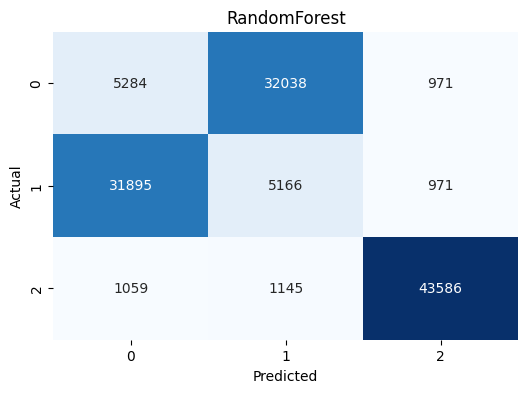

In [103]:
plot_confusion_matrix(y_test, y_pred_rf, "RandomForest")

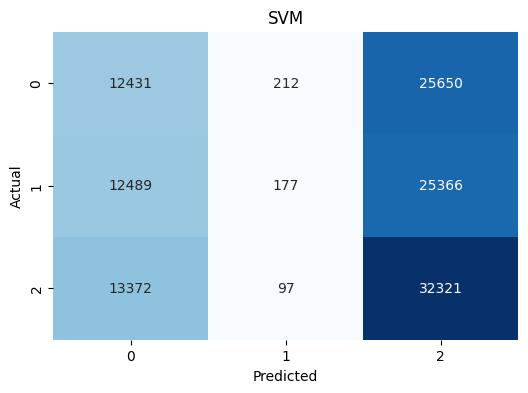

In [104]:
plot_confusion_matrix(y_test,y_pred_svm, "SVM")

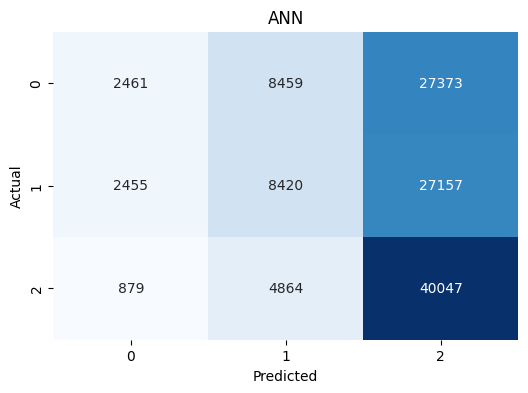

In [105]:
plot_confusion_matrix(y_test, y_pred, "ANN")